# CV07. Stereo camera - Weak calibration

Input: pair(s) of images from 2 camera view on the same scene

Output: Disparty map

- Bước 1: Tìm các cặp điểm đặc trưng trong ảnh (DoG detector)
- Bước 2: Sơ khớ các điểm ảnh để tìm đc các cặp điểm tương đồng
- Bước 3: Tìm ma trận F ==> có thể Xác định các epipolarline
- Bước 4: Thực hiện rectify 2 ảnh sử dụng ma trận F, xem hàm: stereoRectifyUncalibrated
- Bước 5: Stereo matching và tính disparity: phương pháp StereoSGBM 

In [2]:
# Các thư viện cần thiết
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

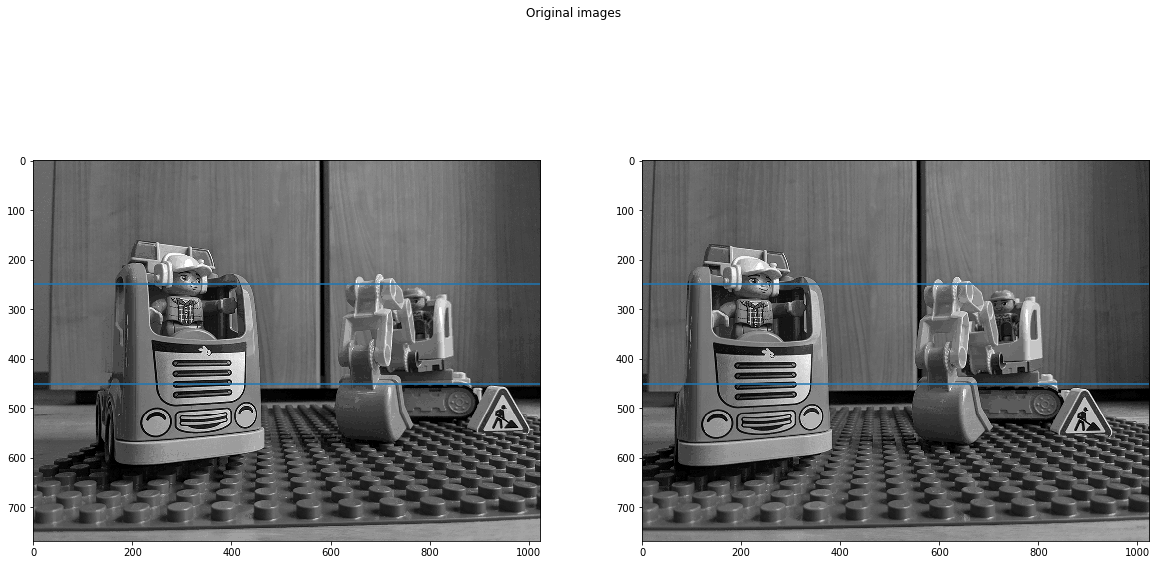

In [3]:
# 0. Read both images and convert to grayscale

img_name1='wk_calib_data/left_img.png'  #uncalibrated camera
img_name2='wk_calib_data/right_img.png' #uncalibrated camera

img1 = cv.imread(img_name1, cv.IMREAD_GRAYSCALE)
img2 = cv.imread(img_name2, cv.IMREAD_GRAYSCALE)

# ------------------------------------------------------------
# PREPROCESSING

# Compare unprocessed images
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img1, cmap="gray")
axes[1].imshow(img2, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Original images")
plt.show()

# Tìm các cặp điểm tương đồng giữa 2 ảnh

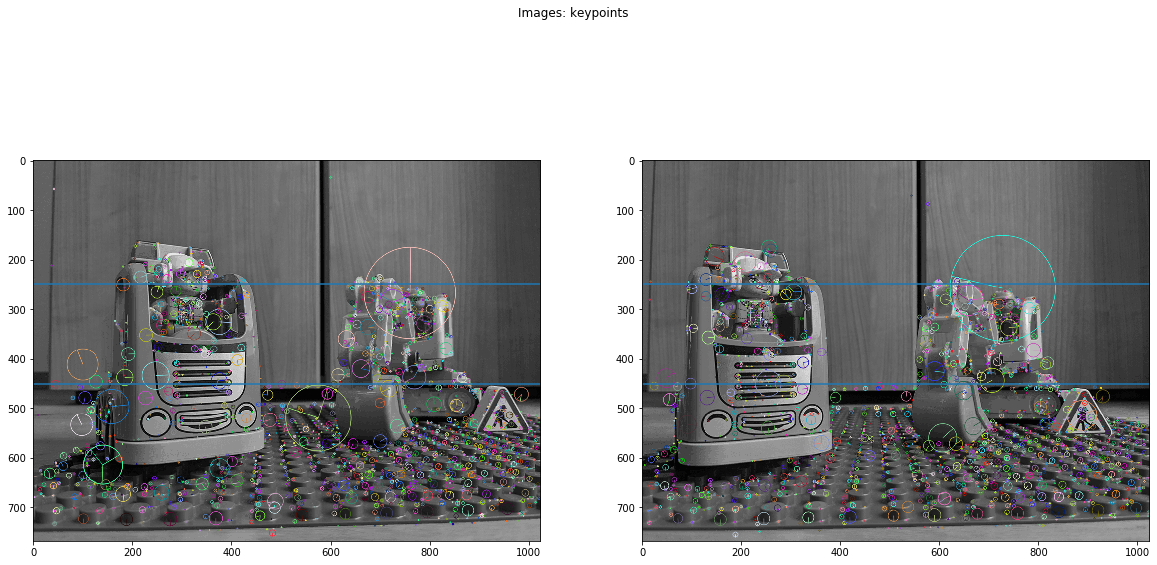

In [5]:
# 1. Phát hiện các điểm đặc trưng và đặc trưng cục bộ trên 2 ảnh. Đặc trưng sử dụng: SIFT, SURF, ..

# Detect keypoints and their descriptors
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html

# Initiate SIFT detector
# sift = cv.SIFT_create() % cho phiên bản 4.5
sift = cv.xfeatures2d.SIFT_create() 

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Visualize keypoints
imgKP_1 = cv.drawKeypoints(
    img1, kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

imgKP_2 = cv.drawKeypoints(
    img2, kp2, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(imgKP_1, cmap="gray")
axes[1].imshow(imgKP_2, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Images: keypoints")
plt.show()

In [6]:
# 2. Tìm các cặp điểm đặc trưng tương đồng giữa 2 ảnh
# 2. Match keypoints in both images
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html

# YOUR CODE HERE
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Keep good matches: calculate distinctive image features
# Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. International Journal of Computer Vision 60, 91–110 (2004). https://doi.org/10.1023/B:VISI.0000029664.99615.94
# https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)      

# YOUR CODE HERE

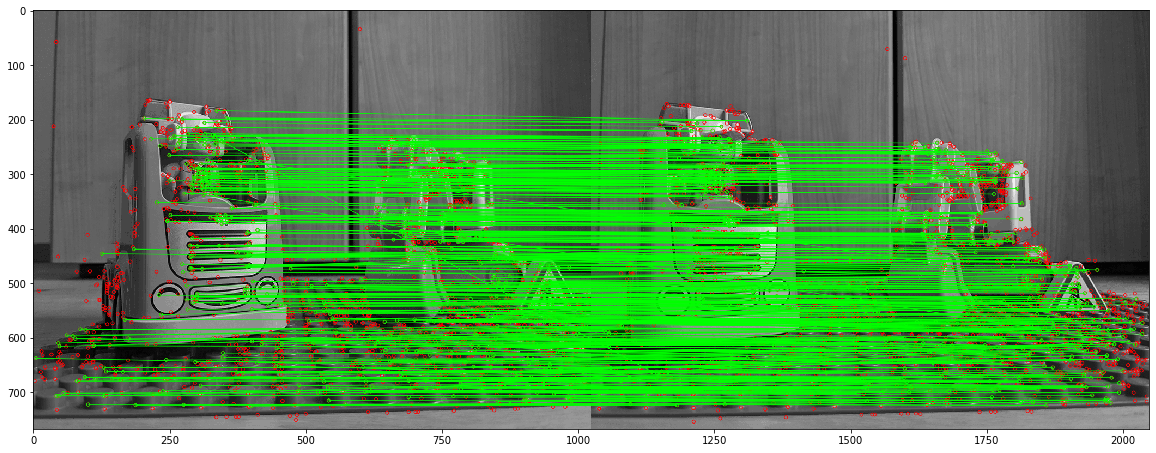

In [13]:
# Draw the keypoint matches between both pictures
# Still based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html

# YOUR CODE HERE
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask,
                   flags=cv.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv.drawMatchesKnn(
    img1, kp1, img2, kp2, matches, None, **draw_params)

#cv.imshow("Keypoint matches", keypoint_matches)
#cv.waitKey(0)
plt.figure(figsize=(20,20))
plt.imshow(keypoint_matches)
# YOUR CODE HERE

# Calibration

In [14]:
# 3. Tìm ma trận F
# Calculate the fundamental matrix for the cameras
# https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

In [15]:
# Fundamental Matrix
print("Fundamental Matrix:")
print(fundamental_matrix)

Fundamental Matrix:
[[ 2.49343244e-07  4.56023039e-05 -3.35118080e-02]
 [-4.51760060e-05  7.29130871e-06 -2.78773472e-01]
 [ 3.47201084e-02  2.72091870e-01  1.00000000e+00]]


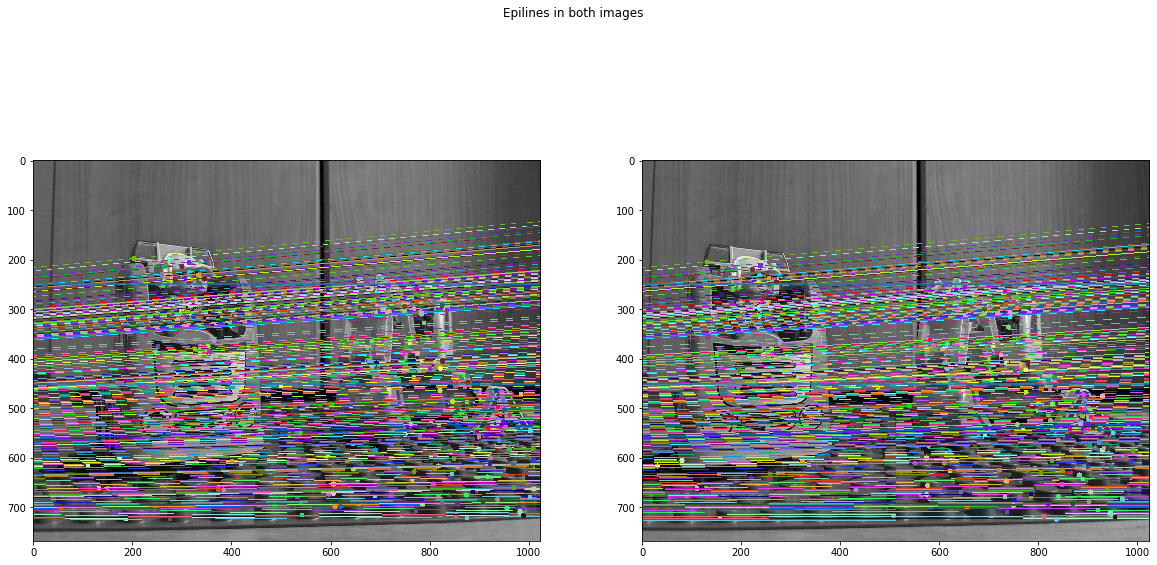

In [17]:
# Visualize epilines
# Adapted from: https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
def drawlines(img1src, img2src, lines, pts1src, pts2src):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1src.shape
    img1color = cv.cvtColor(img1src, cv.COLOR_GRAY2BGR)
    img2color = cv.cvtColor(img2src, cv.COLOR_GRAY2BGR)
    # Edit: use the same random seed so that two images are comparable!
    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv.line(img1color, (x0, y0), (x1, y1), color, 1)
        img1color = cv.circle(img1color, tuple(pt1), 5, color, -1)
        img2color = cv.circle(img2color, tuple(pt2), 5, color, -1)
    return img1color, img2color


# Find epilines corresponding to points in right image (second image)
lines1 = cv.computeCorrespondEpilines(
    pts2.reshape(-1, 1, 2), 2, fundamental_matrix)
lines1 = lines1.reshape(-1, 3)

# drawing its lines on left image
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) 
# YOUR CODE HERE
lines2 = cv.computeCorrespondEpilines(
    pts1.reshape(-1, 1, 2), 1, fundamental_matrix)
lines2 = lines2.reshape(-1, 3)
# YOUR CODE HERE

# drawing its lines on right image
# YOUR CODE HERE
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)
# YOUR CODE HERE

# Display both images with epilines
# YOUR CODE HERE
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img5, cmap="gray")
axes[1].imshow(img3, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Epilines in both images")
plt.show()
# YOUR CODE HERE

In [18]:
# Stereo rectification (uncalibrated variant)
# Adapted from: https://stackoverflow.com/a/62607343
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

print ('H1:')
print(H1)
print ('H2:')
print(H2)

H1:
[[ 3.11136477e-01  1.03683797e-02 -4.02042372e+01]
 [ 3.23033385e-02  2.73241681e-01 -1.44969147e+01]
 [ 4.18415443e-05 -9.00311632e-06  2.59924913e-01]]
H2:
[[ 1.07598945e+00 -5.72518905e-02 -1.69218702e+01]
 [ 1.11184956e-01  9.95498581e-01 -5.51981525e+01]
 [ 1.51175829e-04 -8.04385400e-06  9.25686816e-01]]


In [19]:
# Undistort (rectify) the images and save them
# Adapted from: https://stackoverflow.com/a/62607343
# rectify the left image 
img1_rectified = cv.warpPerspective(img1, H1, (w1, h1))

# rectify the right image
# YOUR CODE HERE
img2_rectified = cv.warpPerspective(img2, H2, (w2, h2))
# YOUR CODE HERE
cv.imwrite("rectified_1.png", img1_rectified)
cv.imwrite("rectified_2.png", img2_rectified)

True

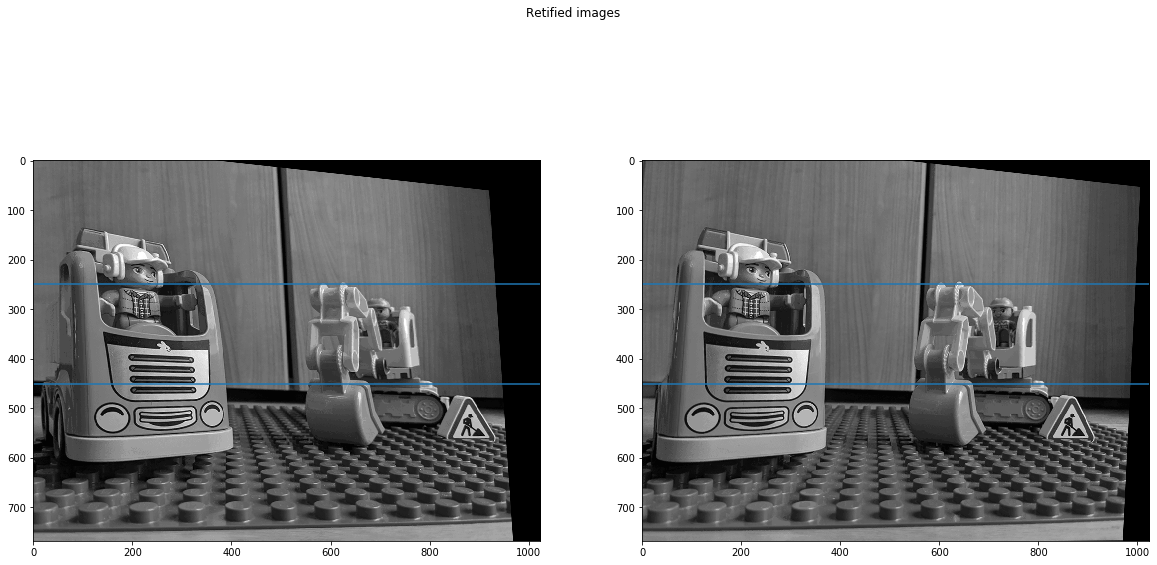

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Retified images")
plt.show()

# 3D estimation: Stereo Matching for the Disparity Map

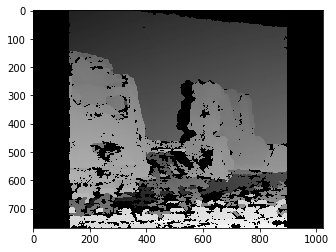

In [21]:
# Sử dụng phương pháp StereoSGBM để tính Disparity Map
# ------------------------------------------------------------
# CALCULATE DISPARITY (DEPTH MAP)
# Adapted from: https://github.com/opencv/opencv/blob/master/samples/python/stereo_match.py
# and: https://docs.opencv.org/master/dd/d53/tutorial_py_depthmap.html

# StereoSGBM Parameter explanations:
# https://docs.opencv.org/4.5.0/d2/d85/classcv_1_1StereoSGBM.html

# YOUR CODE HERE

# Matched block size. It must be an odd number >=1 . Normally, it should be somewhere in the 3..11 range.
#block_size = 11
block_size = 9
min_disp = -128
max_disp = 128
# Maximum disparity minus minimum disparity. The value is always greater than zero.
# In the current implementation, this parameter must be divisible by 16.
num_disp = max_disp - min_disp
# Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct.
# Normally, a value within the 5-15 range is good enough
uniquenessRatio = 5
# Maximum size of smooth disparity regions to consider their noise speckles and invalidate.
# Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
#speckleWindowSize = 200 
speckleWindowSize = 200 #50 #100

# Maximum disparity variation within each connected component.
# If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16.
# Normally, 1 or 2 is good enough.
speckleRange = 2
disp12MaxDiff = 0

stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    disp12MaxDiff=disp12MaxDiff,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size,
)

disparity_SGBM = stereo.compute(img1_rectified, img2_rectified)

# Normalize the values to a range from 0..255 for a grayscale image
disparity_SGBM = cv.normalize(disparity_SGBM, disparity_SGBM, alpha=255,
                              beta=0, norm_type=cv.NORM_MINMAX)
disparity_SGBM = np.uint8(disparity_SGBM)
#cv.imshow("Disparity", disparity_SGBM)
cv.imwrite("disparity_SGBM_norm.png", disparity_SGBM)

# YOUR CODE HERE

plt.imshow(disparity_SGBM, cmap="gray")

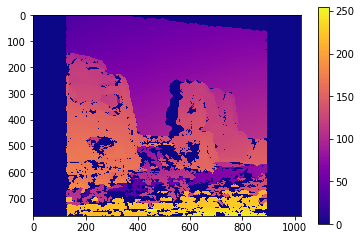

In [22]:
plt.imshow(disparity_SGBM, cmap='plasma')
plt.colorbar()
plt.show()

Adapted from: https://www.andreasjakl.com/understand-and-apply-stereo-rectification-for-depth-maps-part-2/